# Consolidate Adsorption Results
Summarize the adsorption energy by composition, surface type, and bond position

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from ase.db import connect
from ase.io import read
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
width: int = 2  # Number of repeat units in slab directions

In [3]:
co2_energy = json.loads(Path('co2-molecule/co2.json').read_text())['energy']

## Get Lookup Table for Bulk Properties
Get the site information for each structure based on the name

In [4]:
bulk_info = {}  # Name -> key_value_pairs
with connect('../0_relax-bulk/volume-relax.db') as db:
    for row in db.select(supercell=width):
        kv = row.key_value_pairs.copy()
        name = kv.pop('name')
        bulk_info[name] = kv

In [5]:
next(iter(bulk_info.items()))

('CeAlO3', {'a': 'Ce', 'b': 'Al', 'a_val': 3, 'b_val': 3, 'supercell': 2})

## Load the Surface Data
Find the relaxed structures 

In [6]:
adsorbates = []
for relaxed_path in Path('adsorbate/').rglob(f'width-{width}/*/relaxed.extxyz'):
    # Start with a summary based on the path
    _, cell_dir, term, _, site, _ = relaxed_path.parts
    comp = cell_dir.split("_")[0]  # Bulk composition
    term = int(term.split("=")[1])
    record = {
        'comp': comp,
        'term': term,
        'site': site,
    }

    # Get the composition of the surface
    relaxed = read(relaxed_path)
    top_layer_z = relaxed.positions[:-3, :].max()  # highest point without the CO2
    top_layer = relaxed[relaxed.positions[:, 2] > top_layer_z - 1.][:-3]
    record['surface_comp'] = top_layer.get_chemical_formula('metal', empirical=True)

    # Get the identity of the atom being bonded to
    start_data = json.loads((relaxed_path.parent / 'metadata.json').read_text())
    record['site_atom'] = start_data['bond_atom']

    # Get the charge of the metal on the surface
    my_bulk = bulk_info[comp]
    record['site_charge'] = my_bulk['a_val'] if record['site_atom'] == my_bulk['a'] else my_bulk['b_val']

    # Get the adsorption energy
    relaxed_eng = relaxed.get_potential_energy()
    record['adsorption_energy'] = relaxed_eng - start_data['expected_eng']

    adsorbates.append(record)
adsorbates = pd.DataFrame(adsorbates)
print(f'Completed {len(adsorbates)} adsorption calculations')

Completed 796 adsorption calculations


In [7]:
adsorbates.head()

,comp,term,site,surface_comp,site_atom,site_charge,adsorption_energy
0,NdRhO3,1,pi_oxygen,RhO2,Rh,4,0.187609
1,LaLuO3,0,pi_oxygen,LaO,La,3,0.150659
2,NiPtO3,0,mono_metal,NiO2,Ni,-1,-0.096418
3,NiPtO3,0,pi_metal,NiO2,Ni,-1,-0.134859
4,NiPtO3,0,pi_oxygen,NiO2,Ni,-1,-0.103788


Save it to disk

In [8]:
adsorbates.to_csv('adsorbates.csv', index=False)

## Compare Energies by Configuration
Find out if running all the configurations is necessary to find one which bonds

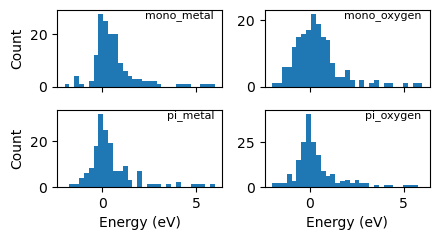

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(4.5, 2.5), sharex=True)

bins = np.linspace(
    np.floor(np.percentile(adsorbates['adsorption_energy'], 10)),
    np.ceil(np.percentile(adsorbates['adsorption_energy'], 90)),
    32
)
for (gid, group), ax in zip(adsorbates.groupby('site'), axs.flatten()):
    ax.text(0.95, 0.9, gid, transform=ax.transAxes, ha='right', fontsize=8)

    ax.hist(group['adsorption_energy'], bins=bins)

for ax in axs[:, 0]:
    ax.set_ylabel('Count')
for ax in axs[-1, :]:
    ax.set_xlabel('Energy (eV)')

fig.tight_layout()